# Introduction

Farmers every year face economic loss and crop waste due to various diseases in plants. I will use image classification using CNN and built a testpad website using which a farmer can take a picture and website will tell him if the plant has a disease or not.

This dataset has data about three types of vegetable (Potato, Tomato, and Pepper), each kind has images of healthy and different types of diseases related to its kind. 

Import libraries

In [1]:
!pip install split_folders

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers,callbacks
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Make directory for each class

In [3]:
from distutils.dir_util import copy_tree

all_plants=['Potato','Tomato','Pepper']
all_classes=os.listdir('../input/plant-village/PlantVillage/')

for plant in all_plants:
    path = os.path.join("./", plant)
    os.mkdir(path)
    plant_path = os.path.join(path, 'classes')
    os.mkdir(plant_path)
    output_path = os.path.join(path, 'dataset')
    os.mkdir(output_path)
    for class_name in all_classes:
        if plant in class_name: 
            print(class_name)
            to_class_path = os.path.join(plant_path, class_name)
            from_class_path = os.path.join('/kaggle/input/plant-village/PlantVillage/', class_name)
            os.mkdir(to_class_path)
            copy_tree(from_class_path, to_class_path)

Potato___healthy
Potato___Late_blight
Potato___Early_blight
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Tomato_Late_blight
Tomato__Tomato_mosaic_virus
Pepper__bell___Bacterial_spot
Pepper__bell___healthy


In the next cell, you can change the (plant) variable to the vegetable that you want to train the model on.

In [4]:
plant='Pepper'
path = os.path.join('/kaggle/working/', plant)
ds_path = os.path.join(path, 'classes')
output= os.path.join(path,'dataset')

I used split_folders library to split datasets to THREE main folders, each has one type of vegetable (Potato, Tomato, and Pepper).

In [5]:
# To split dataset into training, validation, and test set
splitfolders.ratio(ds_path,
                   output=output,
                   seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 2475 files [00:00, 6586.01 files/s]


Define veriables 

In [6]:
img_size=256
batch_size=32

In [7]:
dirs=[x[1] for x in os.walk(output)]
dirs[0]

['test', 'train', 'val']

Using ImageDataGenerator api, which allows to load the images from the **Output** and augment them.

In [8]:
for i in range(3):
    img=ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    zoom_range=0.3,
    brightness_range=(0.2,1.0),
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
    )
    generator = os.path.join(output,dirs[0][i])
    globals()[f"{dirs[0][i]}_generator"]= img.flow_from_directory(
        generator,
        target_size=(img_size,img_size),
        batch_size=batch_size,
        class_mode="sparse"
#         ,save_to_dir="C:\\Code\\potato-disease-classification\\training\\AugmentedImages"
    )

Found 250 images belonging to 2 classes.
Found 1979 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


Display the classes (folders) in dataset

In [9]:
train_generator.class_indices

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}

In [10]:
test_generator.class_indices

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}

In [11]:
val_generator.class_indices

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}

In [12]:
class_names = list(train_generator.class_indices.keys())
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

Build the model

In [13]:
model=models.Sequential([
    layers.Conv2D(32,(3,3), activation='relu',input_shape=(img_size,img_size,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')
])

model.build(input_shape=(batch_size,img_size,img_size,3))

2022-03-02 01:46:55.184111: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Early Stopping

In [16]:
es=callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=1)

Fit the model

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    batch_size=32,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1,
    epochs=10
    ,callbacks=[es]
)

2022-03-02 01:46:56.118062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
62/62 [==============================] - 101s 2s/step - loss: 0.6659 - accuracy: 0.6256 - val_loss: 0.5385 - val_accuracy: 0.7439
Epoch 2/10
62/62 [==============================] - 99s 2s/step - loss: 0.4401 - accuracy: 0.8722 - val_loss: 0.1833 - val_accuracy: 0.9512
Epoch 3/10
62/62 [==============================] - 100s 2s/step - loss: 0.2515 - accuracy: 0.9141 - val_loss: 0.1365 - val_accuracy: 0.9350
Epoch 4/10
62/62 [==============================] - 100s 2s/step - loss: 0.2106 - accuracy: 0.9404 - val_loss: 0.1069 - val_accuracy: 0.9634
Epoch 5/10
62/62 [==============================] - 100s 2s/step - loss: 0.1007 - accuracy: 0.9682 - val_loss: 0.1993 - val_accuracy: 0.9187
Epoch 00005: early stopping


Evaluate the model

In [18]:
score = model.evaluate(test_generator)

8/8 [==============================] - 6s 757ms/step - loss: 0.1769 - accuracy: 0.9400


Plotting the history of the training model

In [19]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 62}

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

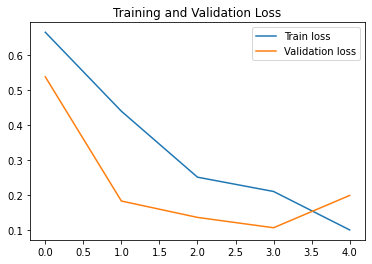

In [22]:
plt.plot( loss,label='Train loss')
plt.plot( val_loss,label='Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

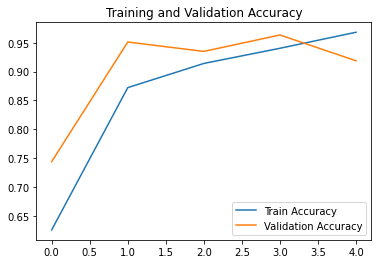

In [23]:
plt.plot(acc,label='Train Accuracy')
plt.plot( val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Prediction using test dataset

In [24]:
# prediction function
def pred_img(img):
#     add one mor dim for image array
    img_array=tf.expand_dims(img,0)
    
#     predict the image
    pred=model.predict(img_array)
    
#     Select the class of the predicted image
    pred_class=class_names[np.argmax(pred[0])]
#     Accuracy of the prediction
    confidence=round((np.max(pred[0])*100),2)
    
    return pred_class, confidence

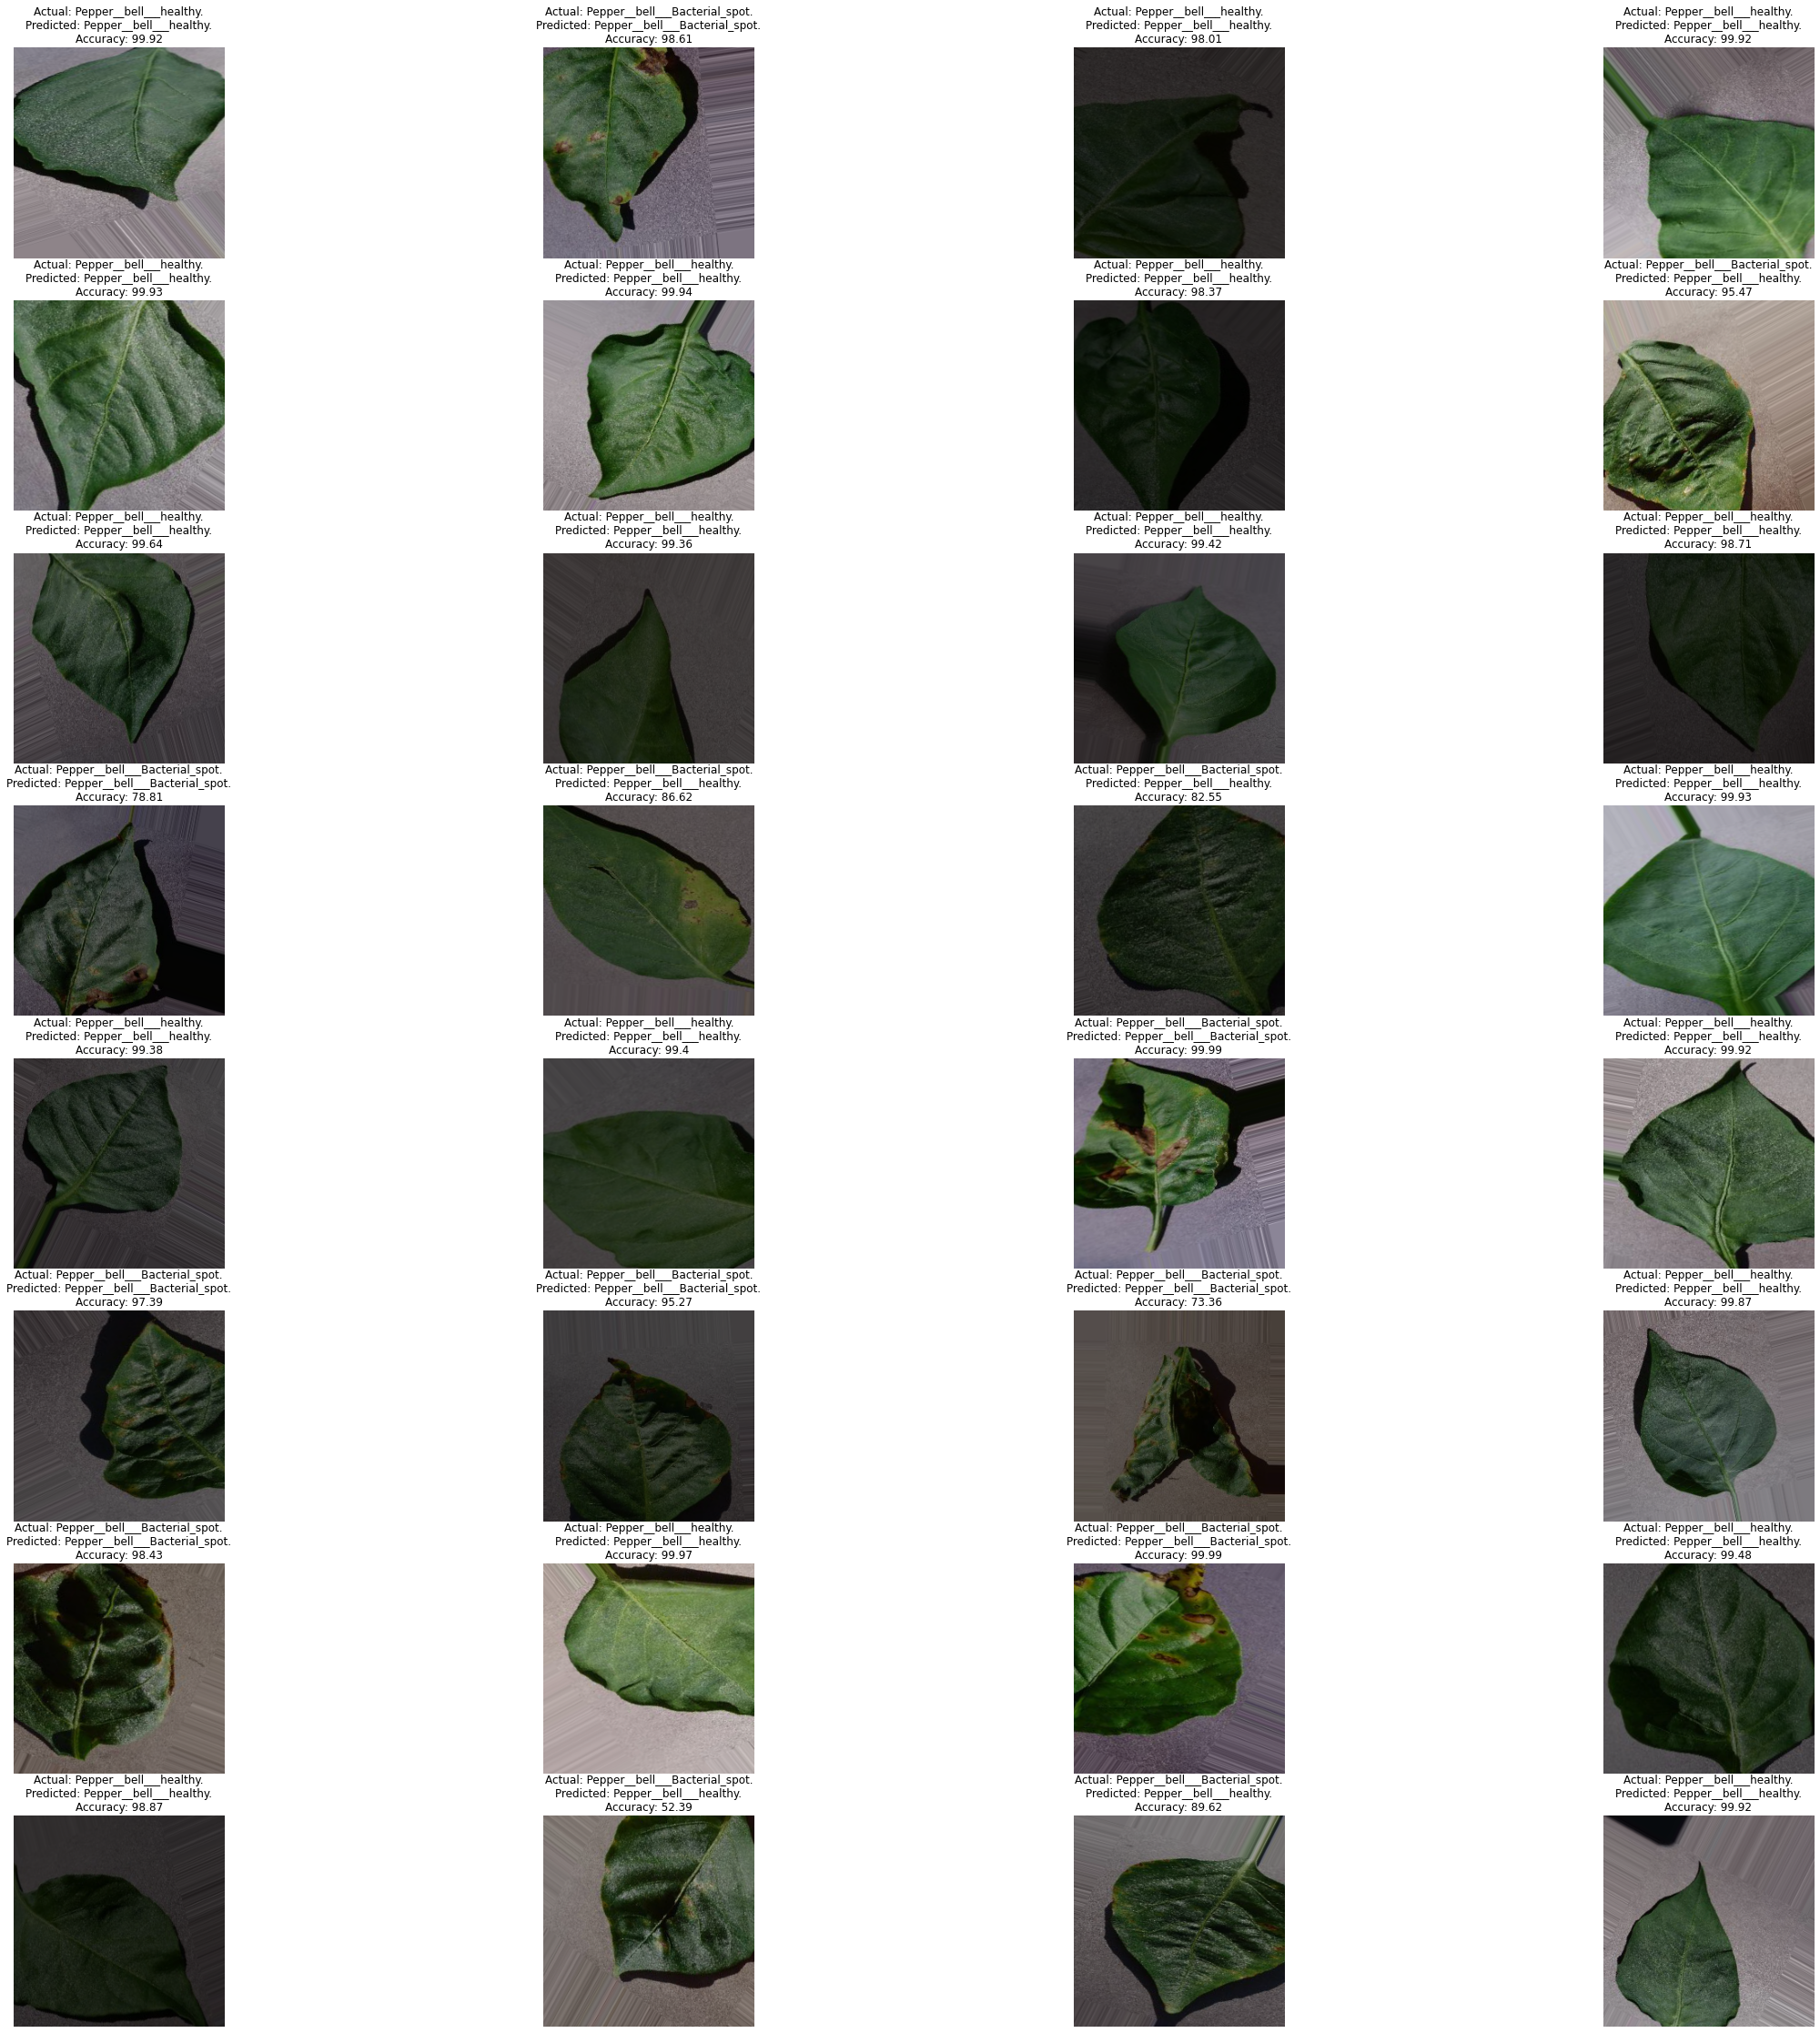

In [25]:
plt.figure(figsize=(40,40))

batch__size=len(test_generator.__getitem__(1)[0])
for i in range (0,batch__size):
#     image array in test_generator first batch
    image=test_generator.__getitem__(1)[0][i]
#     label number in test_generator first batch
    label=test_generator.__getitem__(1)[1][i]
#    predict the image and get the predicted class and the accuracy
    pred_class, confidence = pred_img(image)
#    the actual class of the image
    actual_class= class_names[int(label)]
#    plot the image with its info
    col=int(batch__size/4)
    ax=plt.subplot(col,4,i+1)
    plt.imshow(image)
    plt.title(
        f'Actual: {actual_class}.\nPredicted: {pred_class}.\nAccuracy: {confidence}'
    )
    plt.axis('off')

Save the model

In [26]:
# model.save(f'models/{plant}')

Delete the plants folders

In [27]:
import shutil
all_plants=['Potato','Tomato','Pepper']
for plant in all_plants:
    shutil.rmtree(f"/kaggle/working/{plant}")